In [133]:
# убеждаемся, что используем видеокарту
!nvidia-smi

Wed Mar 10 19:05:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   1733MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [134]:
# Подключаем библиотеки
from torchvision import models
from torch.autograd import Variable
from PIL import Image
from tensorflow.keras.preprocessing import image
from types import SimpleNamespace

import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import numpy as np
import os, time
import scipy
import json
import argparse


In [135]:
# Подключаем диск 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
# !unzip -q '/content/drive/My Drive/datasets/images/dataset1.zip' -d '/content'

In [185]:
# Задаем пути к нашим данным
path = '/content/dataset1/images_prepped_train/' 
listID = os.listdir(path)
labels = '/content/dataset1/annotations_prepped_train/'
labelsID = os.listdir(labels)
print(listID)
print(labelsID)

['0016E5_01680.png', '0006R0_f01800.png', '0016E5_06120.png', '0016E5_06090.png', '0001TP_007590.png', '0006R0_f02880.png', '0016E5_06780.png', '0016E5_07380.png', '0016E5_04500.png', '0006R0_f03360.png', '0016E5_02220.png', '0016E5_01740.png', '0016E5_05760.png', '0016E5_00570.png', '0006R0_f03120.png', '0016E5_07590.png', '0016E5_01080.png', '0016E5_05580.png', '0016E5_01710.png', '0001TP_007890.png', '0016E5_07830.png', '0006R0_f02490.png', '0016E5_04950.png', '0016E5_05460.png', '0016E5_02340.png', '0016E5_00780.png', '0016E5_04770.png', '0006R0_f03420.png', '0016E5_07080.png', '0006R0_f03390.png', '0006R0_f01440.png', '0006R0_f03930.png', '0006R0_f02250.png', '0016E5_04560.png', '0016E5_07470.png', '0001TP_007230.png', '0016E5_04470.png', '0006R0_f03630.png', '0016E5_05550.png', '0016E5_07020.png', '0016E5_08490.png', '0006R0_f01680.png', '0006R0_f01140.png', '0001TP_008460.png', '0016E5_01650.png', '0006R0_f03690.png', '0001TP_007770.png', '0016E5_07050.png', '0016E5_02370.png', 

In [186]:
target = torch.randint(0, 10, (1,))
one_hot = torch.nn.functional.one_hot(target, 10)
one_hot, target



(tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]), tensor([3]))

In [195]:

num_class = 12
img_widht = 176
img_height = 240

In [196]:
arr = Image.open(labels + labelsID[0])
arr = np.array(arr)
arr.shape

(360, 480)

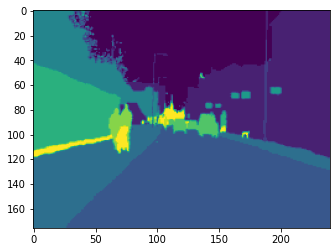

In [197]:
plt.imshow(torchvision.transforms.functional.resize(Image.open(labels+labelsID[0]), (img_width,img_height)))
plt.show()

In [198]:
# Создаем класс для собственных данных, наследуя свойства стандартного датасета
class CustomDataset(data.Dataset):
    def __init__(self, listID, labelsID, path, labels, num_class, img_width, img_height, transforms = None): 
        # Инициализируем атрибуты (они абсолютно производные. У вас они могут быть совсем другими)
        self.listID = listID # listID список имен каждого экземпляра
        self.labels = labels # labels - то, что скормим как yTrain
        self.transforms = transforms # если нужны какие-то преобразования
        self.path = path # путь, где лежат данные
        self.labelsID = labelsID
        self.num_class = num_class
        self.img_width = img_width
        self.img_height = img_height

    def __getitem__(self, index):        
        # Открываем папку с данными (можно использовать numpy.fromfile, PIL.Image.open)
        ID = self.listID[index] # итерируем по каждому элементу в списке
        image_ = np.array(torchvision.transforms.functional.resize(Image.open(path+ID), (img_width,img_height))) # извлекаем картинку по его ID

        # Открываем папку с данными (можно использовать numpy.fromfile, PIL.Image.open)
        ID_Y = self.labelsID[index] # итерируем по каждому элементу в списке
        image_Y = np.array(torchvision.transforms.functional.resize(Image.open(labels+ID_Y), (img_width,img_height))) # извлекаем картинку по его ID

        # Если transforms заполнено, то:
        if self.transforms:
            image_ = self.transforms(image_) # то, что лежит в transforms применяем к картинку
        trainX = image_ # наша картинка уходит в xTrain для этой итерации

        trainY = image_Y # лейбл для этой картинки уходит в yTrain

        # Возвращаем пару экзмепляр-метка
        return trainX, trainY 

    def __len__(self):
        # Здесь общий размер вашего датасета
        return len(listID)

In [199]:
# Задаем набор трансформаций mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [200]:
customData = CustomDataset(listID, labelsID, path, labels, num_class, img_width, img_height, transform)

trainLoader = torch.utils.data.DataLoader(dataset=customData,
                                           batch_size=2, 
                                           shuffle=True,
                                           num_workers=0)

In [201]:
dataiter = iter(trainLoader)
images = dataiter.next()
images[0].shape

torch.Size([2, 3, 176, 240])

In [202]:
images = dataiter.next()
images[1].shape

torch.Size([2, 176, 240])

In [203]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True, progress=True, num_classes=21, aux_loss=None)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [204]:
class Classifier(nn.Module): 
    def __init__(self):
        super(Classifier, self).__init__()
        self.cl = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(512, 12, kernel_size=(1, 1), stride=(1, 1)))
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cl(x)
        # out = self.softmax(out)
        return out


class Aux_classifier(nn.Module): 
    def __init__(self):
        super(Aux_classifier, self).__init__()
        self.aux_cl = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Dropout(p=0.1, inplace=False),
            nn.Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1)))
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.aux_cl(x)
        # out = self.softmax(out)
        return out

In [205]:
model_cl = Classifier()
model_aux_cl = Aux_classifier()
model_cl.train(), model_aux_cl.train()

(Classifier(
   (cl): Sequential(
     (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(512, 12, kernel_size=(1, 1), stride=(1, 1))
   )
 ), Aux_classifier(
   (aux_cl): Sequential(
     (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
   )
 ))

In [207]:
for param in model.parameters(): # поскольку мы будем тренировать под наш сет только последний слой
    param.requires_grad = False # не будем обновлять веса всей сети. Заморозим их

# Заменим последний слой для настройки под наш датасет
model.classifier = model_cl
model.aux_classifier = model_aux_cl

In [208]:
# Проверка, если GPU включен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [209]:
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [210]:
def dice_coef(y_pred, y_true):
    # Возвращаем площадь пересечения деленную на площадь объединения двух областей
    return (2. * torch.sum(y_true * y_pred) + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.) 

def ohe_tr(label, num_class=12, dimension=4):
    y = torch.nn.functional.one_hot(label, num_class)
    y = torch.transpose(torch.transpose(y, dimension-1,dimension-2), dimension-3,dimension-2)
    return y

history_loss = []
history_dice = []

batchSize = 128 # Зададим размер батча
numEpochs = 10 # Зададим количество эпох для обучения
learningRate = 0.00001 # Зададим параметр learningRate для оптимайзера

In [213]:
criterion = nn.CrossEntropyLoss() #.to(device) # Функция ошибки
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learningRate)# Оптимизатор. Поскольку тренируем только слой классификатор, то его параметры и подаем на вход

# Обучим наш последний слой
for epoch in range(numEpochs):
    for i, (images, label) in enumerate(trainLoader):          
        optimizer.zero_grad() # обнуляем градиенты
        outputs = model(images.to(device)) # подаем наше изображение на вход

        outputs_ = nn.functional.softmax(outputs['out'], dim=1)

        loss = criterion(outputs_, label.to(device, torch.long)) # считаем ошибку (torch.int64)
        loss.backward() # берем производную
        optimizer.step() # делаем шаг оптимизатором

        dice_c = dice_coef(outputs_, ohe_tr(label.to(device, torch.long)))

        history_loss.append(loss.item())
        history_dice.append(dice_c.item())
        
        if (i+1) % 10 == 0:
            print('Эпоха: [%d/%d], Шаг: [%d/%d], Потеря: %.4f, Dice: %.4f' 
                  % (epoch+1, numEpochs, i+1, len(customData)//batchSize, loss, dice_c.item()))

Эпоха: [1/10], Шаг: [10/2], Потеря: 2.2992, Dice: 0.2747
Эпоха: [1/10], Шаг: [20/2], Потеря: 2.0864, Dice: 0.5023
Эпоха: [1/10], Шаг: [30/2], Потеря: 2.0929, Dice: 0.4990
Эпоха: [1/10], Шаг: [40/2], Потеря: 1.9531, Dice: 0.6431
Эпоха: [1/10], Шаг: [50/2], Потеря: 2.0614, Dice: 0.5322
Эпоха: [1/10], Шаг: [60/2], Потеря: 1.9840, Dice: 0.6125
Эпоха: [1/10], Шаг: [70/2], Потеря: 1.9614, Dice: 0.6353
Эпоха: [1/10], Шаг: [80/2], Потеря: 1.9948, Dice: 0.6039
Эпоха: [1/10], Шаг: [90/2], Потеря: 1.9722, Dice: 0.6251
Эпоха: [1/10], Шаг: [100/2], Потеря: 2.0496, Dice: 0.5466
Эпоха: [1/10], Шаг: [110/2], Потеря: 1.9404, Dice: 0.6617
Эпоха: [1/10], Шаг: [120/2], Потеря: 1.9146, Dice: 0.6853
Эпоха: [1/10], Шаг: [130/2], Потеря: 1.8743, Dice: 0.7301
Эпоха: [1/10], Шаг: [140/2], Потеря: 1.9227, Dice: 0.6778
Эпоха: [1/10], Шаг: [150/2], Потеря: 1.9925, Dice: 0.6065
Эпоха: [1/10], Шаг: [160/2], Потеря: 1.9018, Dice: 0.7023
Эпоха: [1/10], Шаг: [170/2], Потеря: 1.9689, Dice: 0.6329
Эпоха: [1/10], Шаг: [18

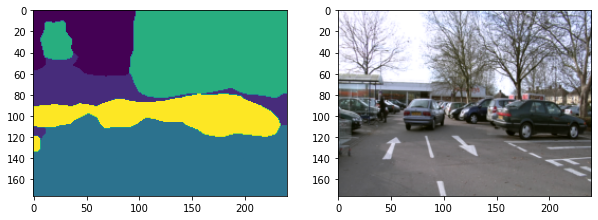

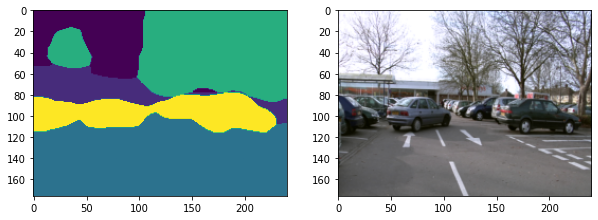

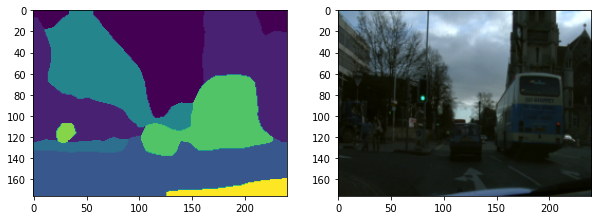

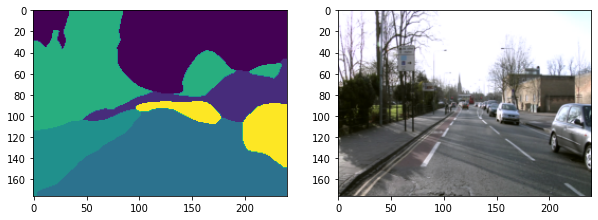

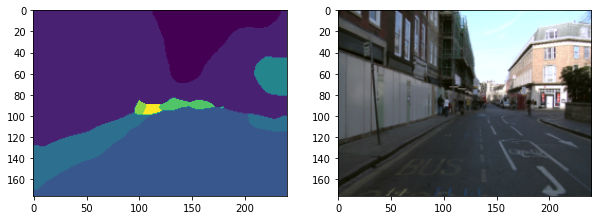

In [214]:
for i in range(5):
    dataiter = iter(trainLoader)
    images = dataiter.next()

    out = model(images[0].to(device))['out']

    out_ = nn.functional.softmax(out, dim=1)
    out_ = torch.argmax(out_, 1)[0]


    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                                        std=[1/0.229, 1/0.224, 1/0.255])

    inv_tensor = inv_normalize(images[0][0])
    img_ = inv_tensor.cpu().numpy().transpose(1,2,0)
    img_[img_ > 1.] = 1.
    img_[img_ < 0] = 0.

    out_ = out_.cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(out_)
    plt.subplot(222)
    plt.imshow(img_)
plt.show()

In [216]:
# Пункт 2

from torchvision import models # здесь лежат предобученные сетки

#import argparse
from types import SimpleNamespace # простой класс, где можно прописать параметры
import json

# Для визуализации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import time
import scipy
from google.colab import files

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора

In [217]:
config = SimpleNamespace() # Создаем базовый класс пространства имен
config.content = '/content/drive/My Drive/datasets/dz/Content.jpg'    # наша основная картинка
config.style   = '/content/drive/My Drive/datasets/dz/Style.jpg'    # наша стилизованная картинка
config.maxSize = 400 # максимально допустимый размер изображения
config.totalStep = 600 # общее количество шагов за эпоху
config.step = 10 # шаг
config.sampleStep = 100 # шаг для сохранения образца
config.styleWeight = 100 #вес на стиль
config.lr = .003

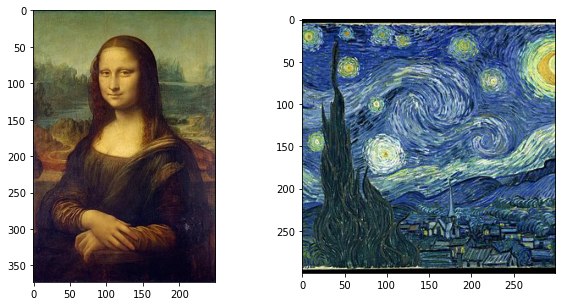

In [218]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open('/content/drive/My Drive/datasets/dz/Content.jpg'))
plt.subplot(1, 2, 2)
plt.imshow(Image.open('/content/drive/My Drive/datasets/dz/Style.jpg'))
plt.show()

In [220]:
# Проверка, если GPU включен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [221]:
vgg16 = torchvision.models.vgg16(pretrained=True).eval() # загружаем готовую vgg16 с предобученными весами, переключаем в режим проверки (evaluate

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [222]:
class PretrainedNet(nn.Module):
    def __init__(self):
        # Инициализируем нашу модель
        super(PretrainedNet, self).__init__()
        self.select = [0, 5, 7, 10, 15] # те слои, через которые мы будем пропускать свое изображение
        self.pretrainedNet = models.vgg19(pretrained=True).to(device) # подгружаем предобученную сетку
        
    def forward(self, x):
        features = [] # Извлекаем по индексам, которые мы прописали выше, feature map из сетки
        output = x
        for layerIndex in range(len(self.pretrainedNet.features)):
          output = self.pretrainedNet.features[layerIndex](output)
          if layerIndex in self.select:
            features.append(output)
        return features

In [223]:
def load_image(image_path, transform=None, maxSize=None, shape=None):
    # Загружаем изображение
    image = Image.open(image_path)
    
    # Если указан максимальный размер, то меняем размер нашего изображения
    if maxSize:
        scale = maxSize / max(image.size) # задаем масштаб для преобразования размера
        size = np.array(image.size) * scale # масштабированный размер
        image = image.resize(size.astype(int), Image.ANTIALIAS) # преобразуем 
        
    # Если указана форма изображением, меняем форму
    if shape:
        image = image.resize(shape, Image.LANCZOS)

    # Если указаны методы трансформирования, то применяем его
    if transform:
        image = transform(image).unsqueeze(0) # трансформировали + вытянули до батча
    
    return image.to(device)

In [224]:
# Методы трансформирования изображения
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [225]:
# Загружаем оригинал и стиль для картинок, применив нужные методы
content = load_image(config.content, transform, maxSize=config.maxSize)
style = load_image(config.style, transform, shape=[content.size(3), content.size(2)])

# Создаем место под тензор для конечной картинки, указываем, что дифференцируем 
target = content.clone().requires_grad_(True)

target.shape

torch.Size([1, 3, 400, 268])

In [226]:
model1 = PretrainedNet().eval() # для использования весов предобученной сетки переводим ее в режим eval
optimizer = torch.optim.Adam([target], lr=0.1) # наша цель - не менять веса сетки, а менять изображение-тензор, поэтому указываем его в качестве параметра
contentCriteria = nn.MSELoss()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [227]:
for step in range(config.totalStep):
    # Для каждого из изображений извлекаем feature map
    targetFeatures = model1.forward(target)
    contentFeatures = model1.forward(content) 
    styleFeatures = model1.forward(style)
    
    styleLoss = 0
    contentLoss = 0

    for f1, f2, f3 in zip(targetFeatures, contentFeatures, styleFeatures):
        # Вычисляем потери для оригинала и конечной картинки
        contentLoss += contentCriteria(f1, f2)
        #print(contentLoss)

        # Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
        _, c, h, w = f1.size() # пропускаем batch
        f1 = f1.reshape(c, h*w).to(device) 
        f3 = f3.reshape(c, h*w).to(device)

        # Находим матрицу Грама для конечной и стиля
        f1 = torch.mm(f1, f1.t()) 
        f3 = torch.mm(f3, f3.t())

        # Потери для стиля и конечной картинки
        kf1 = 1 / (4 * (len(f1)*len(f3))**2)
        kf2 = 1 / 4 * (len(f1)*len(f3))**2
        kf3 = 1 / (c * w * h)
        styleLoss += contentCriteria(f1,f3) * kf2
    # Прописываем конечную функцию потерь 
    loss = styleLoss + contentLoss
    #print(betta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (step+1) % config.step == 0:
        print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля: {}' 
               .format(step+1, config.totalStep, contentLoss.item(), styleLoss.item()))

    if (step+1) % config.sampleStep == 0: # сохраняем нашу картинку
        img = target.clone().squeeze() # создаем место под тензор
        img = img.clamp_(0, 1) # оставить значения, попадающие в диапазон между 0,1
        torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [10/600], Ошибка для оригинала: 24.5566, Ошибка для стиля: 1.6141858051928883e+17
Шаг [20/600], Ошибка для оригинала: 28.1159, Ошибка для стиля: 7.598879478382592e+16
Шаг [30/600], Ошибка для оригинала: 28.9438, Ошибка для стиля: 4.33328871220183e+16
Шаг [40/600], Ошибка для оригинала: 29.5554, Ошибка для стиля: 2.809668820795392e+16
Шаг [50/600], Ошибка для оригинала: 30.0881, Ошибка для стиля: 2.014742100259635e+16
Шаг [60/600], Ошибка для оригинала: 30.5192, Ошибка для стиля: 1.558735973515264e+16
Шаг [70/600], Ошибка для оригинала: 30.8622, Ошибка для стиля: 1.2686115769155584e+16
Шаг [80/600], Ошибка для оригинала: 31.1595, Ошибка для стиля: 1.0697994735190016e+16
Шаг [90/600], Ошибка для оригинала: 31.4171, Ошибка для стиля: 9251244665208832.0
Шаг [100/600], Ошибка для оригинала: 31.6441, Ошибка для стиля: 8150595407970304.0
Шаг [110/600], Ошибка для оригинала: 31.8450, Ошибка для стиля: 7276935172325376.0
Шаг [120/600], Ошибка для оригинала: 32.0115, Ошибка для стиля: 656300

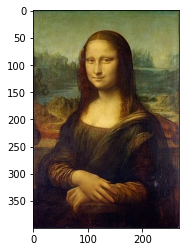

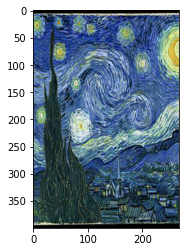

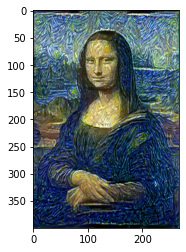

In [228]:
def inference(target):
    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                                            std=[1/0.229, 1/0.224, 1/0.255])
    inv_content = inv_normalize(target[0])

    styled_img_mp = inv_content.cpu().detach().numpy().transpose(1,2,0)
    styled_img_mp[styled_img_mp > 1.] = 1.
    styled_img_mp[styled_img_mp < 0] = 0.

    plt.imshow(styled_img_mp)
    plt.show()
    return styled_img_mp
content_ = inference(content)
style_ = inference(style)
img_1 =  inference(target)

In [229]:
class PretrainedNet(nn.Module):
    def __init__(self):
        # Инициализируем нашу модель
        super(PretrainedNet, self).__init__()
        self.select = [0, 5, 7, 10, 15] # те слои, через которые мы будем пропускать свое изображение
        self.pretrainedNet = models.vgg19(pretrained=True).to(device) # подгружаем предобученную сетку
        for ln in (4, 9, 18, 27, 36):                                 # В этих слоях модели будем менять MaxPooling на AveragePooling
          l = self.pretrainedNet.features[ln]
          new_layer = torch.nn.AvgPool2d(kernel_size=l.kernel_size, stride=l.stride, padding=l.padding, ceil_mode=l.ceil_mode)      # Замена слоев на AveragePooling с теми же параметрами
          self.pretrainedNet.features[ln] = new_layer

    def forward(self, x):
        features = [] # Извлекаем по индексам, которые мы прописали выше, feature map из сетки
        output = x
        for layerIndex in range(len(self.pretrainedNet.features)):
          output = self.pretrainedNet.features[layerIndex](output)
          if layerIndex in self.select:
            features.append(output)
        return features

In [230]:
# Создаем место под тензор для конечной картинки, указываем, что дифференцируем 
target = content.clone().requires_grad_(True)

In [231]:
model2 = PretrainedNet().eval() # для использования весов предобученной сетки переводим ее в режим eval
optimizer = torch.optim.Adam([target], lr=0.1) # наша цель - не менять веса сетки, а менять изображение-тензор, поэтому указываем его в качестве параметра
contentCriteria = nn.MSELoss()

In [232]:
for step in range(config.totalStep):
    # Для каждого из изображений извлекаем feature map
    targetFeatures = model2.forward(target)
    contentFeatures = model2.forward(content) 
    styleFeatures = model2.forward(style)
    
    styleLoss = 0
    contentLoss = 0

    for f1, f2, f3 in zip(targetFeatures, contentFeatures, styleFeatures):
        # Вычисляем потери для оригинала и конечной картинки
        contentLoss += contentCriteria(f1, f2)
        #print(contentLoss)

        # Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
        _, c, h, w = f1.size() # пропускаем batch
        f1 = f1.reshape(c, h*w).to(device) 
        f3 = f3.reshape(c, h*w).to(device)

        # Находим матрицу Грама для конечной и стиля
        f1 = torch.mm(f1, f1.t()) 
        f3 = torch.mm(f3, f3.t())

        # Потери для стиля и конечной картинки
        kf1 = 1 / (4 * (len(f1)*len(f3))**2)
        kf2 = 1 / 4 * (len(f1)*len(f3))**2
        kf3 = 1 / (c * w * h)
        styleLoss += contentCriteria(f1,f3) * kf2
    # Прописываем конечную функцию потерь 
    loss = styleLoss + contentLoss
    #print(betta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (step+1) % config.step == 0:
        print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля: {}' 
               .format(step+1, config.totalStep, contentLoss.item(), styleLoss.item()))

    if (step+1) % config.sampleStep == 0: # сохраняем нашу картинку
        img = target.clone().squeeze() # создаем место под тензор
        img = img.clamp_(0, 1) # оставить значения, попадающие в диапазон между 0,1
        torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [10/600], Ошибка для оригинала: 6.1329, Ошибка для стиля: 7668860064890880.0
Шаг [20/600], Ошибка для оригинала: 6.9901, Ошибка для стиля: 3543761678237696.0
Шаг [30/600], Ошибка для оригинала: 7.2347, Ошибка для стиля: 1830763498569728.0
Шаг [40/600], Ошибка для оригинала: 7.4831, Ошибка для стиля: 1139080624603136.0
Шаг [50/600], Ошибка для оригинала: 7.6474, Ошибка для стиля: 807991259430912.0
Шаг [60/600], Ошибка для оригинала: 7.7635, Ошибка для стиля: 617941775155200.0
Шаг [70/600], Ошибка для оригинала: 7.8531, Ошибка для стиля: 495953194778624.0
Шаг [80/600], Ошибка для оригинала: 7.9296, Ошибка для стиля: 410959583641600.0
Шаг [90/600], Ошибка для оригинала: 7.9953, Ошибка для стиля: 348160517996544.0
Шаг [100/600], Ошибка для оригинала: 8.0540, Ошибка для стиля: 300145266655232.0
Шаг [110/600], Ошибка для оригинала: 8.1075, Ошибка для стиля: 262071153328128.0
Шаг [120/600], Ошибка для оригинала: 8.1565, Ошибка для стиля: 231062798073856.0
Шаг [130/600], Ошибка для оригина

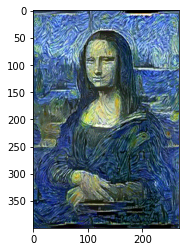

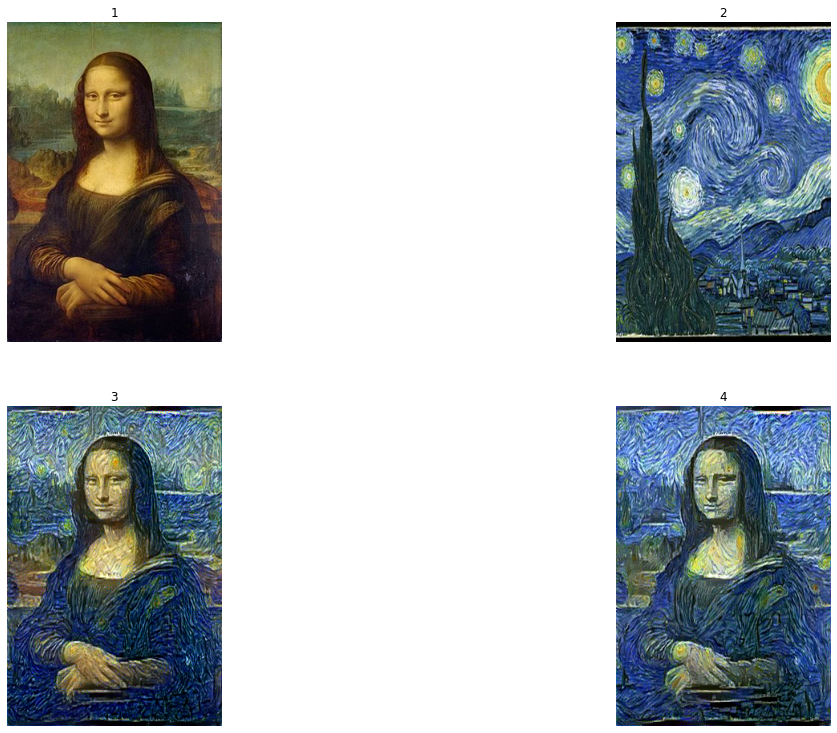

In [233]:
img_2 = inference(target)
def rez_plot(*arg):
    x = len(arg)
    col = int(x**0.5)
    plt.figure(figsize=(col*10,col*10))
    for z, i in enumerate(arg):
        plt.subplot(col+1,col, z+1)
        plt.title(z+1)
        plt.imshow(i)
        plt.axis('off') 
    plt.show()

rez_plot(content_, style_, img_1, img_2)

In [234]:
# Пункт 3
# Создаем место под тензор для конечной картинки, указываем, что дифференцируем 
target = content.clone().requires_grad_(True)


model3 = PretrainedNet().eval() # для использования весов предобученной сетки переводим ее в режим eval
optimizer = torch.optim.Adam([target], lr=1.0) # наша цель - не менять веса сетки, а менять изображение-тензор, поэтому указываем его в качестве параметра
contentCriteria = nn.MSELoss()

In [236]:
for step in range(config.totalStep):
    # Для каждого из изображений извлекаем feature map
    targetFeatures = model3.forward(target)
    contentFeatures = model3.forward(content) 
    styleFeatures = model3.forward(style)
    
    styleLoss = 0
    contentLoss = 0

    for f1, f2, f3 in zip(targetFeatures, contentFeatures, styleFeatures):
        # Вычисляем потери для оригинала и конечной картинки
        contentLoss += contentCriteria(f1, f2*1000)
        #print(contentLoss)

        # Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
        _, c, h, w = f1.size() # пропускаем batch
        f1 = f1.reshape(c, h*w).to(device) 
        f3 = f3.reshape(c, h*w).to(device)

        # Находим матрицу Грама для конечной и стиля
        f1 = torch.mm(f1, f1.t()) 
        f3 = torch.mm(f3, f3.t())

        # Потери для стиля и конечной картинки   
        kf1 = 1 / (4 * (len(f1)*len(f3))**2)
        kf2 = 1 / 4 * (len(f1)*len(f3))**2
        kf3 = 1 / (c * w * h)
        styleLoss += contentCriteria(f1, f3) * kf2 *100    
    # Прописываем конечную функцию потерь 
    loss = styleLoss/100 + contentLoss*10000                #   *1000
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (step+1) % config.step == 0:
        print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля: {}' 
               .format(step+1, config.totalStep, contentLoss.item(), styleLoss.item()))

    if (step+1) % config.sampleStep == 0: # сохраняем нашу картинку
        img = target.clone().squeeze() # создаем место под тензор
        img = img.clamp_(0, 1) # оставить значения, попадающие в диапазон между 0,1
        torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [10/600], Ошибка для оригинала: 6005829.0000, Ошибка для стиля: 4.132236496456594e+19
Шаг [20/600], Ошибка для оригинала: 6007626.0000, Ошибка для стиля: 1.1545587873717682e+19
Шаг [30/600], Ошибка для оригинала: 6008140.0000, Ошибка для стиля: 3.6119965774360084e+18
Шаг [40/600], Ошибка для оригинала: 6008057.0000, Ошибка для стиля: 1.4483294926646804e+18
Шаг [50/600], Ошибка для оригинала: 6008036.0000, Ошибка для стиля: 7.661493916805366e+17
Шаг [60/600], Ошибка для оригинала: 6008003.0000, Ошибка для стиля: 4.7807287843723674e+17
Шаг [70/600], Ошибка для оригинала: 6007988.0000, Ошибка для стиля: 3.343034180488397e+17
Шаг [80/600], Ошибка для оригинала: 6007976.0000, Ошибка для стиля: 2.5502790813168435e+17
Шаг [90/600], Ошибка для оригинала: 6007970.0000, Ошибка для стиля: 2.0614674789695488e+17
Шаг [100/600], Ошибка для оригинала: 6007966.0000, Ошибка для стиля: 1.732976182464348e+17
Шаг [110/600], Ошибка для оригинала: 6007965.0000, Ошибка для стиля: 1.4958859131866317e+17
Ш

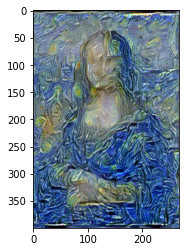

In [237]:
img_3 =  inference(target)

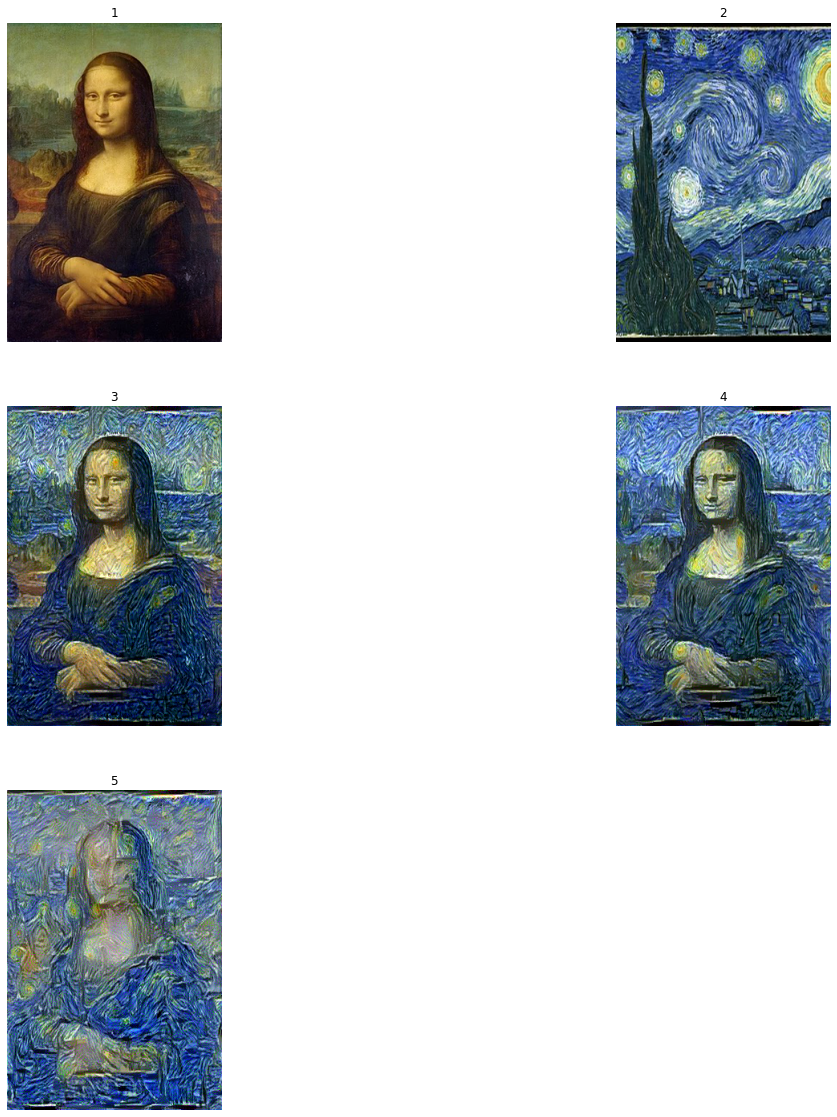

In [245]:
rez_plot(content_, style_, img_1, img_2, img_3)